In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [118]:
def policy_improvement_inner(S, A, R, gamma, V, policy, theta):

    # policy evaluation
    for _ in xrange(100):
        delta = 0
        for s in S:
            v = V[s]
            a = policy[s]
            V[s] = sum([p * (r + gamma * V[s2]) for (p, s2, r) in R(s, a)])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break

    # policy improvement
    policy_stable = True
    for s in S:
        old_action = policy[s]
        policy[s] = max(A(s), key = lambda a: sum([p * (r + gamma * V[s2]) for (p, s2, r) in R(s, a)]))
        if old_action != policy[s]:
            policy_stable = False

    return V, policy, policy_stable


def policy_improvement(S, A, R, gamma, V, policy, theta):
    """
    S: set of states
    A: A(s) = set of actions available in state s
    R: function R(s, a): [(p, s2, r)] where
        p: prob of transition
        s2: new state
        r: reward
    V: array V[s] = value of state s
    policy: array policy[s] = action to take in state s
    theta: convergence criterion
    
    V and policy are modified in-place, and are returned
    """
    
    policy_stable = False
    while not policy_stable:
        V, policy, policy_stable = policy_improvement_inner(S, A, R, gamma, V, policy, theta)
        
    return V, policy


In [104]:
# Jack's car rental

MULT = 1

MAX_CARS = 20 * MULT
MAX_MOVE = int(ceil(5 * MULT))
MU1_in  = 3 * MULT
MU1_out = 3 * MULT
MU2_in  = 2 * MULT
MU2_out = 4 * MULT

FACT = np.cumprod(np.hstack([[1], 1 + np.arange(MAX_CARS).astype(float)]))

P1OUT = [ np.exp(- MU1_out) * MU1_out ** k / FACT[k] for k in xrange(MAX_CARS + 1) ]
P2OUT = [ np.exp(- MU2_out) * MU2_out ** k / FACT[k] for k in xrange(MAX_CARS + 1) ]
P1IN = [ np.exp(- MU1_in) * MU1_in ** k / FACT[k] for k in xrange(MAX_CARS + 1) ]
P2IN = [ np.exp(- MU2_in) * MU2_in ** k / FACT[k] for k in xrange(MAX_CARS + 1) ]

RENTAL_FEE = 10.
MOVE_COST = 2.

# possible states: up to 20 cars in 1st location, up to 20 cars in 2nd location
S = [ (n, m) for n in range(MAX_CARS+1) for m in range(MAX_CARS+1) ] 

A = lambda (n1, n2): range(max(-MAX_MOVE, -n2, n1 - MAX_CARS), 1 + min(MAX_MOVE, n1, MAX_CARS - n2))

# reward is determined by the state transition
# a is number cars moved from location 1 to location 2. Negative numbers represents cars moved from 2 to 1
def R(s, a):
    """
    Generate a set of transistions (p, s2, r) where:
       p: prob of transition
       s2: new state
       r: return (expected or actual)
    """
    n1, n2 = s
    n1 = n1 - a
    n2 = n2 + a
    
    # up to n1 cars rented out in location 1
    for n1out in xrange(1 + n1):
        if n1out < n1:
            p1out = P1OUT[n1out] 
        else:
            p1out = 1 - sum(P1OUT[k] for k in xrange(n1))
        
        max1in = MAX_CARS - (n1 - n1out)
        for n1in in xrange(1 + max1in):
            if n1in < max1in:
                p1in = P1IN[n1in] 
            else:
                p1in = 1 - sum(P1IN[k] for k in xrange(max1in))            
            
            for n2out in xrange(1 + n2):
                if n2out < n2:
                    p2out = P2OUT[n2out] 
                else:
                    p2out = 1 - sum(P2OUT[k] for k in xrange(n2))
                
                max2in = MAX_CARS - (n2 - n2out)
                for n2in in xrange(1 + max2in):
                    if n2in < max2in:
                        p2in = P2IN[n2in] 
                    else:
                        p2in = 1 - sum(P2IN[k] for k in xrange(max2in))
                    
                    p = p1in * p1out * p2in * p2out
                    s2 = (n1 + n1in - n1out, n2 + n2in - n2out)
                    r = RENTAL_FEE * (n1out + n2out) - MOVE_COST * abs(a)
                    
                    yield (p, s2, r)
                    


In [105]:
%%time

# Aggregate transitions by state and cache results

Rcache = {(s, a, s2): (0., s2, 0.) for s in S for a in A(s) for s2 in S}

for s in S:
    for a in A(s):
        for p, s2, r in R(s, a):
            p0, _, r0 = Rcache[(s, a, s2)]
            Rcache[(s, a, s2)] = (p0 + p, s2, (r0 * p0 + r * p) / (p0 + p))
            
Rold = R
R = lambda s, a: ( Rcache[(s, a, s2)] for s2 in S )

CPU times: user 2min 47s, sys: 428 ms, total: 2min 47s
Wall time: 2min 47s


In [116]:
S = [ (n1, n2) for n1 in xrange(1 + MAX_CARS) for n2 in xrange(1 + MAX_CARS) ]
V = { s: 0 for s in S}
policy = { s: 0 for s in S }


gamma = 0.9
theta = 1e-1

In [128]:
%%time
policy0 = policy.copy()
V, policy, stable = policy_improvement_inner(S, A, R, gamma, V, policy, theta)

CPU times: user 1.44 s, sys: 16 ms, total: 1.46 s
Wall time: 1.42 s


In [129]:
print policy == policy0
print stable

True
True


In [130]:
%%time
V, policy = policy_improvement(S, A, R, gamma, V, policy, theta)

CPU times: user 1.44 s, sys: 20 ms, total: 1.46 s
Wall time: 1.45 s


In [131]:
matV = np.array([ [ V[(i, j)] for j in xrange(1 + MAX_CARS) ] for i in xrange(1 + MAX_CARS) ])
matpolicy = np.array([ [ policy[(i, j)] for j in xrange(1 + MAX_CARS) ] for i in xrange(1 + MAX_CARS) ])

<IPython.core.display.Javascript object>


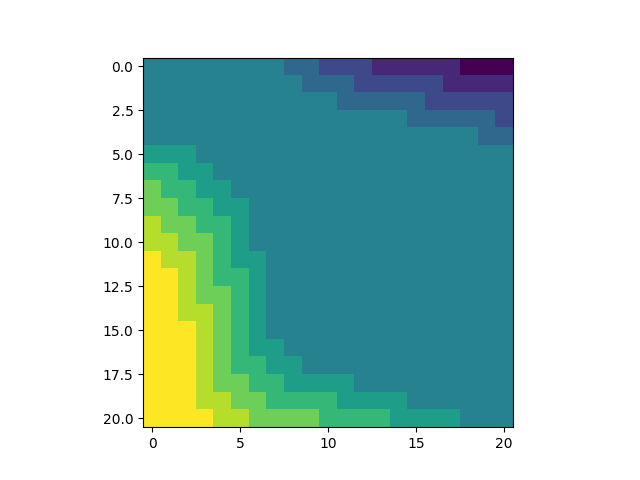

In [132]:
figure(); imshow(matpolicy)

<IPython.core.display.Javascript object>


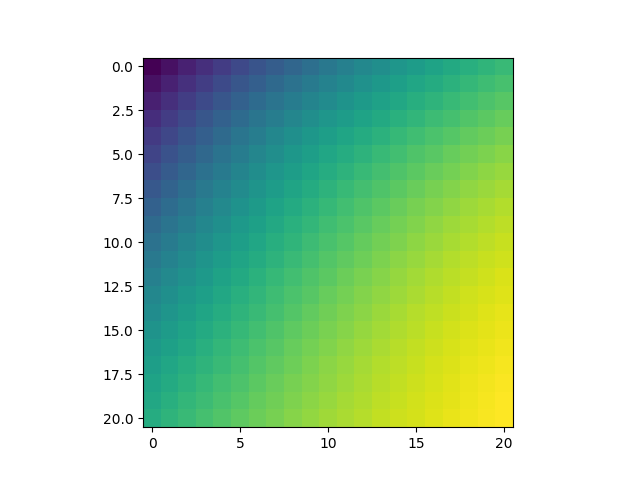

In [133]:
figure(); imshow(matV)

In [83]:
cumsum(range(5))

array([ 0,  1,  3,  6, 10])